## March Madness Logistic Regression

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from math import sin, cos, sqrt, atan2, radians
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
import statsmodels.formula.api as smf

np.random.seed(0)

/Users/travis.petersen/Library/Python/3.8/lib/python/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [3]:
mm_data = pd.read_csv('NCAA_Tourney_2002_2022.csv').query("season!=2019").reset_index(drop=True)

In [4]:
#list(mm_data.columns)

In [5]:
mm_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
mm_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [6]:
mm_data['diff_dist'] = mm_data['dist1'] - mm_data['dist2']

## Pythag College Basketball
E(W%) = points scored^11.5 / (points scored^11.5+points allowed^11.5)

In [7]:
mm_data['exp_win1'] = (mm_data['team1_adjoe']**11.5)/ ((mm_data['team1_adjde']**11.5)+(mm_data['team1_adjoe']**11.5))
mm_data['exp_win2'] = (mm_data['team2_adjoe']**11.5)/ ((mm_data['team2_adjde']**11.5)+(mm_data['team2_adjoe']**11.5))

## Log Odds
P(W) = (A - A * B) / (A + B - 2*A*B)

In [8]:
mm_data['team1_log5'] = (mm_data['exp_win1'] - (mm_data['exp_win1']*mm_data['exp_win2']))/ (mm_data['exp_win1']+mm_data['exp_win2']-(2*mm_data['exp_win1']*mm_data['exp_win2']))

In [9]:
(mm_data
 [['team1_adjoe','team1_teamname','season','team2_teamname','team1_adjde','exp_win1','exp_win2','team1_log5']]
 .sort_values("team1_log5", ascending=False).head())

,team1_adjoe,team1_teamname,season,team2_teamname,team1_adjde,exp_win1,exp_win2,team1_log5
988,119.7250,Kentucky,2015,Hampton,85.8155,0.978741,0.312700,0.990214
529,116.1109,UCLA,2008,MS Valley St,89.3351,0.953236,0.197019,0.988106
77,126.8080,Gonzaga,2021,Norfolk St,88.7549,0.983748,0.435433,0.987418
266,117.6452,Duke,2004,Alabama St,89.6445,0.957950,0.246514,0.985842
124,120.1300,Michigan,2021,TX Southern,87.9102,0.973168,0.372453,0.983900


## Seed Diff

In [10]:
mm_data['seed_diff'] = mm_data['team1_seed'] - mm_data['team2_seed']

In [11]:
mm_data[['game_id','exp_win1','exp_win2','team2_score',
         'team1_score','diff_dist','team1_log5','team1_id','team2_id','team1_seed','team2_seed','seed_diff']].head()

,game_id,exp_win1,exp_win2,team2_score,team1_score,diff_dist,team1_log5,team1_id,team2_id,team1_seed,team2_seed,seed_diff
0,2022-1314-1181,0.853260,0.927374,77,81,-13.433263,0.312890,1314,1181,8,2,6
1,2022-1242-1437,0.940565,0.932803,65,81,-635.035142,0.532712,1242,1437,1,2,-1
2,2022-1242-1314,0.940565,0.853260,69,72,-112.798837,0.731293,1242,1314,1,8,-7
3,2022-1242-1274,0.940565,0.792545,50,76,-1201.318434,0.805536,1242,1274,1,10,-9
4,2022-1314-1389,0.853260,0.624505,49,69,436.787027,0.777591,1314,1389,8,15,-7


## Split Data

In [12]:
mm_data.dropna(subset=['team1_log5'], inplace=True)

In [13]:
mm_data['team1_win'] = (mm_data['team1_score']>mm_data['team2_score']).astype(int)

In [14]:
training_columns = ['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                    'team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff']
mm_data_1 = mm_data.sample(frac=.5, random_state=15)[training_columns]
mm_data_2 = mm_data[~mm_data.index.isin(mm_data_1.index)][training_columns].reset_index(drop=True)
mm_data_1 = mm_data_1.reset_index(drop=True)

In [15]:
mm_data_2['team1_win'] = 0
mm_data_2['diff_dist'] = mm_data_2['diff_dist']*-1
mm_data_2['team1_log5'] = 1-mm_data_2['team1_log5']
mm_data_2['game_id'] = (mm_data_2['game_id'].str.split('-', expand=True)[0] 
                           + '-' + mm_data_2['game_id'].str.split('-', expand=True)[2] 
                           + '-' + mm_data_2['game_id'].str.split('-', expand=True)[1]
                           ) 
mm_data_2['seed_diff'] = mm_data_2['seed_diff']*-1
mm_data_2.columns = ['game_id', 'season', 'team1_win', 'exp_win2', 'exp_win1', 'team1_score', 'team2_score', 'diff_dist', 'team1_log5',
 'team2_id', 'team1_id','seed_diff']

In [16]:
mm_train = pd.concat([mm_data_2, mm_data_1]).reset_index(drop=True)

In [17]:
train, test = train_test_split(mm_train, train_size=.7)

In [18]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Initial Check

In [19]:
train.groupby('team1_win')['team1_log5'].mean()

team1_win
0    0.366538
1    0.603904
Name: team1_log5, dtype: float64

In [20]:
train.groupby('team1_win')['seed_diff'].mean()

team1_win
0    4.112867
1   -3.023310
Name: seed_diff, dtype: float64

In [21]:
train.groupby('team1_win')['diff_dist'].mean()

team1_win
0    225.866486
1   -171.647730
Name: diff_dist, dtype: float64

## Train Logit

In [22]:
logit = LogisticRegression()
logit.fit(X=train[['seed_diff']], y=train['team1_win'])

LogisticRegression()

In [23]:
seed_smlogit = smf.logit("team1_win ~ seed_diff", train).fit()
seed_smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.564620
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  872
Model:                          Logit   Df Residuals:                      870
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Feb 2023   Pseudo R-squ.:                  0.1853
Time:                        19:08:16   Log-Likelihood:                -492.35
converged:                       True   LL-Null:                       -604.31
Covariance Type:            nonrobust   LLR p-value:                 1.259e-50
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0528      0.078      0.680      0.496      -0.099       0.205
seed_diff     -0.1616      0.013    -12.753      0.000      -0.186      -0.137
==============================================================================
"""

In [24]:
test['prob'] = logit.predict_proba(test[['seed_diff']])[:,1]
test['prediction'] = logit.predict(test[['seed_diff']])

In [25]:
test[['game_id','seed_diff','team1_win','prob','prediction']].head()

,game_id,seed_diff,team1_win,prob,prediction
0,2006-1338-1245,-7,1,0.765661,1
1,2003-1231-1338,5,0,0.319694,0
2,2005-1196-1437,-1,0,0.553395,1
3,2016-1386-1332,7,0,0.253815,0
4,2022-1240-1120,13,0,0.114261,0


In [26]:
test.groupby('team1_win')['prob'].mean()

team1_win
0    0.384460
1    0.617057
Name: prob, dtype: float64

<AxesSubplot: xlabel='prob', ylabel='team1_log5'>

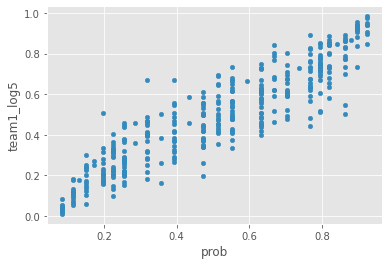

In [27]:
test.plot(kind='scatter', x='prob',y='team1_log5')

In [28]:
confusion_matrix(test['team1_win'], test['prediction'])

array([[121,  59],
       [ 54, 140]])

In [29]:
accuracy_score(test['team1_win'], test['prediction'],)

0.6978609625668449

In [30]:
precision_score(test['team1_win'], test['prediction'])

0.7035175879396985

In [31]:
recall_score(test['team1_win'], test['prediction'])

0.7216494845360825

In [32]:
f1_score(test['team1_win'], test['prediction'])

0.712468193384224

In [33]:
log_loss(test['team1_win'].values, test['prob'].values, labels=[0,1])

0.575996177464342

In [34]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

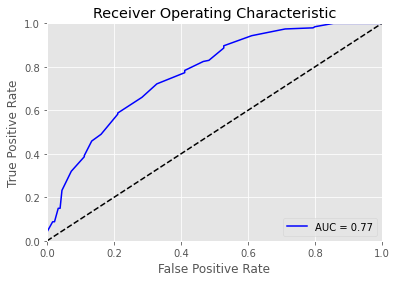

In [35]:
fpr, tpr, thresholds = roc_curve(test['team1_win'].values, test['prob'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [36]:
roc_auc_score(test['team1_win'].values, test['prob'].values)

0.769201030927835

## Add Seed Difference & Distance

In [37]:
logit = LogisticRegression()
logit.fit(train[['team1_log5','diff_dist','seed_diff']], train['team1_win'])

LogisticRegression()

In [38]:
smlogit = smf.logit("team1_win ~ team1_log5 + diff_dist + seed_diff", train).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.548318
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  872
Model:                          Logit   Df Residuals:                      868
Method:                           MLE   Df Model:                            3
Date:                Thu, 02 Feb 2023   Pseudo R-squ.:                  0.2088
Time:                        19:08:23   Log-Likelihood:                -478.13
converged:                       True   LL-Null:                       -604.31
Covariance Type:            nonrobust   LLR p-value:                 2.023e-54
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9337      0.393     -4.925      0.000      -2.703      -1.164
team1_log5     3.9752      0.772      5.152      0.000       2.463       5.487
diff_dist  -3.331e-05   6.83e-05     -0.488      0.626      -0.000       0.000
seed_diff     -0.0512      0.024     -2.133      0.033      -0.098      -0.004
==============================================================================
"""

In [39]:
test['prob'] = logit.predict_proba(test[['team1_log5','diff_dist','seed_diff']])[:,1]
test['prediction'] = logit.predict(test[['team1_log5','diff_dist','seed_diff']])

In [40]:
accuracy_score(test['team1_win'], test['prediction'],)

0.7085561497326203

In [41]:
precision_score(test['team1_win'], test['prediction'])

0.717948717948718

In [42]:
recall_score(test['team1_win'], test['prediction'])

0.7216494845360825

In [43]:
f1_score(test['team1_win'], test['prediction'])

0.7197943444730078

In [44]:
log_loss(test['team1_win'].values, test['prob'].values)

0.56976491956348

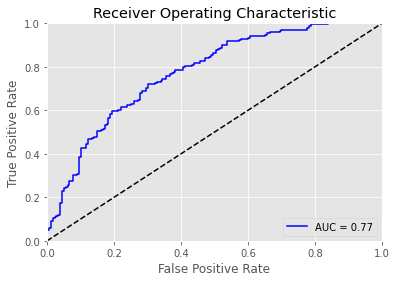

In [45]:
fpr, tpr, thresholds = roc_curve(test['team1_win'].values, test['prob'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [46]:
roc_auc_score(test['team1_win'].values, test['prob'].values)

0.7736254295532645

## Create Example Submission

In [47]:
example_submission = pd.read_csv('NCAA_Tourney_2002_2022.csv').query("season==2019").reset_index(drop=True)

In [48]:
example_submission['seed_diff'] = example_submission['team1_seed'] - example_submission['team2_seed']

In [49]:
example_submission['prob'] = seed_smlogit.predict(example_submission['seed_diff'])

In [50]:
example_submission[['game_id','prob']].head()

,game_id,prob
0,2019-1192-1341,0.513200
1,2019-1125-1396,0.513200
2,2019-1295-1300,0.513200
3,2019-1113-1385,0.513200
4,2019-1278-1257,0.393636


In [51]:
example_submission[['game_id','prob']].shape

(67, 2)

In [52]:
example_submission[['game_id','prob']].to_csv("trp_example_submission.csv", index=False)